In [75]:
import numba, sys
from numpy import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

@numba.jit(nopython=True) # random position initialization
def initialize(r1, r2, L):
    for i in range(N):
        r1[i, 0] = 0.3 * L * np.random.rand()
        r1[i, 1] = 0.3 * L * np.random.rand()
        r1[i, 2] = 0.3 * L * np.random.rand()
        
        r2[i, 0] = 0.6 * L + 0.3 * L * np.random.rand()
        r2[i, 1] = 0.6 * L + 0.3 * L * np.random.rand()
        r2[i, 2] = 0.6 * L + 0.3 * L * np.random.rand()
    return r1, r2

@numba.jit(nopython=True)
def minimum_image(dr, L):
    return dr - L * np.round(dr / L)

@numba.jit(nopython=True)
def Morse(dist, De, a, r_eq):
    return De * (1 - np.exp(-a * (dist - r_eq)))**2 - De

@numba.jit(nopython=True)
def calculate_distance(r1, r2, L):
    dx = minimum_image(r1[0] - r2[0], L)
    dy = minimum_image(r1[1] - r2[1], L)
    dz = minimum_image(r1[2] - r2[2], L)
    return np.sqrt(dx*dx + dy*dy + dz*dz)

@numba.jit(nopython=True)
def calculate_action(r1, r2, n, N, kBT, L, m, De, a, r_eq, hbar):
    action = 0.0
    
    for d in range(3):
        dr1_forward = minimum_image(r1[(n+1)%N, d] - r1[n, d], L)
        dr1_backward = minimum_image(r1[n, d] - r1[(n-1)%N, d], L)
        action += m * N * kBT**2 * (dr1_forward**2 + dr1_backward**2) / (2.0 * hbar**2)
    
    for d in range(3):
        dr2_forward = minimum_image(r2[(n+1)%N, d] - r2[n, d], L)
        dr2_backward = minimum_image(r2[n, d] - r2[(n-1)%N, d], L)
        action += m * N * kBT**2 * (dr2_forward**2 + dr2_backward**2) / (2.0 * hbar**2)
    
    dist = calculate_distance(r1[n], r2[n], L)
    action += Morse(dist, De, a, r_eq) / N
    
    return action

@numba.jit(nopython=True)
def Monte_Carlo(r1, r2, kBT, count, L, De, a, r_eq, hbar): #Monte Carlo Sweep
    delta = 0.82 # Maximum size of trial displacement
    for step in range(2*N): # Preform N random particle displacements
        polymer = np.random.randint(0, 2)
        index = np.random.randint(0, N) 

        if polymer == 0:
            r1_old = r1[index]
            r1_old_action = calculate_action(r1, r2, index, N, kBT, L, m, De, a, r_eq, hbar)

            r1_new = r1_old
            for i in range(3):
                r1_new[i] += 2*delta*(np.random.rand()-0.5)
                r1_new[i] = r1_new[i] % L
                
            r1[index] = r1_new
            r1_new_action = calculate_action(r1, r2, index, N, kBT, L, m, De, a, r_eq, hbar)

            if np.random.rand() > np.exp(-(r1_new_action - r1_old_action)/kBT):
                r1[index] = r1_old 
            else:
                count+=1
        else:
            r2_old = r2[index]
            r2_old_action = calculate_action(r1, r2, index, N, kBT, L, m, De, a, r_eq, hbar)

            r2_new = r2_old
            for i in range(3):
                r2_new[i] += 2*delta*(np.random.rand()-0.5)
                r2_new[i] = r2_new[i] % L
                
            r2[index] = r2_new
            r2_new_action = calculate_action(r1, r2, index, N, kBT, L, m, De, a, r_eq, hbar)

            if np.random.rand() > np.exp(-(r2_new_action - r2_old_action)/kBT):
                r2[index] = r2_old
            else:
                count+=1
    return r1, r2, count

N = 100
L = 10.0
m = 1.0 
De = 4.7446
a = 1.440558
r_eq = 0.7416

steps = 1000000 # Number of sweeps
Nsamp = 500 # Averaging frequency
kBT = (3.167*10**(-6))*20000.0 #kBT in atomic units
hbar = 1

r1 = np.zeros([N, 3]) 
r2 = np.zeros([N, 3]) 
r1, r2 = initialize(r1, r2, L) 

rs = []
Es = []
count = 0

for step in tqdm(range(steps)): 
    r1, r2, count = Monte_Carlo(r1, r2, kBT, count, L, De, a, r_eq, hbar)
    
    if(step%Nsamp==0 and step>0): # Every Nsamp steps, compute expectations
        for i in range(N):
            rs.append(calculate_distance(r1[i], r2[i], L))

MC Run with N= 100 Number of MC steps= 1000000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:49<00:00, 20198.84it/s]

Done!


Text(0, 0.5, '$P(x)$')

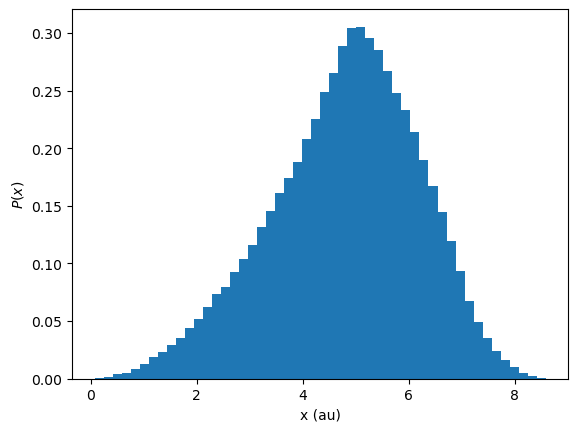

In [76]:
fig, ax = plt.subplots()
ax.hist(rs[200:],histtype="bar",density=True, bins=50)
ax.set_xlabel("x (au)")
ax.set_ylabel(r"$P(x)$")

# avg_energy = calculate_virial_energy(all_distances, De, a, r_eq, N)

# print("Acceptance Rate: ", (count/(N*steps))*100, "%")
# print(r"<E> = ", avg_energy)

# def moorse(r, De, a, r_eq, N):
#     energy = 0
#     for r_n in r:
#         term1 = De * (1 - np.exp(-a * (r_n - r_eq)))**2
#         term2 = -De
#         term3 = a * De * r_n * np.exp(-a * (r_n - r_eq)) * (1 - np.exp(-a * (r_n - r_eq)))
#         energy += term1 + term2 + term3
    # return energy / len(r)

# xs = np.linspace(min(xx[200:]),max(xx[200:]),20000 )
# plt.plot(xs,morse_ground_state(xs, De, a, r_eq, m),color='m',linewidth='2',label = r'$P(x) = |\Psi_0^* \Psi_0|$ ')
# plt.legend(loc='best')
# plt.show()